In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [3]:
from regime_tickers import custom_subset_1

In [4]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = custom_subset_1,
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [6]:
# Calculate Daily Log Returns
# 1. Group by 'symbol' to ensure calculations are done within each ticker's data.
# 2. Apply a transformation (log return calculation) to the 'close' price within each group.

df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

# The first log return for each symbol will be NaN because there's no previous day to compare to.
# This is expected and correct.

In [7]:
# Calculate 20-day Rolling Standard Deviation (Volatility)
window_size = 20

df_adj['rolling_volatility_20'] = df_adj.groupby('symbol')['log_returns'].transform(
    lambda x: x.rolling(window=window_size, min_periods=window_size).std()
)

In [8]:
# Bollinger Bands
bb_window = 20
bb_window_dev = 2

def calculate_bollinger_bands_for_group(group_df, window, window_dev):
    bb = ta.volatility.BollingerBands(
        close=group_df['close'], window=window, window_dev=window_dev
    )
    return pd.DataFrame({
        'bb_upper': bb.bollinger_hband(),
        'bb_middle': bb.bollinger_mavg(),
        'bb_lower': bb.bollinger_lband()
    }, index=group_df.index) # Ensure the returned DataFrame has the correct timestamp index

bb_results = df_adj.groupby('symbol').apply(
    lambda x: calculate_bollinger_bands_for_group(x, bb_window, bb_window_dev)
)

# Joining is now seamless because both df_adj and bb_results have unique, aligned MultiIndexes.
df_adj = pd.merge(df_adj.reset_index(), bb_results.reset_index(), 
                  on=['timestamp', 'symbol'], how='left').set_index('timestamp')

C:\Users\sergi\AppData\Local\Temp\ipykernel_16252\3437752798.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bb_results = df_adj.groupby('symbol').apply(


In [9]:
# Calculate Average True Range (ATR)
def compute_atr_per_symbol(group, window=20):
    atr = ta.volatility.AverageTrueRange(
        high=group['high'], 
        low=group['low'], 
        close=group['close'], 
        window=window
    )
    group[f'atr_{window}'] = atr.average_true_range()
    return group

# Apply ATR calculation per symbol
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)

C:\Users\sergi\AppData\Local\Temp\ipykernel_16252\1372294970.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)


In [10]:
# Calculate Volume Percentage Change
df_adj['volume_pct_change'] = df_adj.groupby('symbol')['volume'].transform(
    lambda x: x.pct_change()
)

In [11]:
# Calculate 10-day Momentum
momentum_window = 10
df_adj['momentum_10'] = df_adj.groupby('symbol')['close'].transform(
    lambda x: (x / x.shift(momentum_window)) - 1
)

In [12]:
# Calculate RSI
def compute_rsi_per_symbol(group, window=20):
    rsi = ta.momentum.RSIIndicator(close=group['close'], window=window)
    group[f'rsi_{window}'] = rsi.rsi()
    return group

# Apply the RSI calculation grouped by symbol
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_rsi_per_symbol)


C:\Users\sergi\AppData\Local\Temp\ipykernel_16252\2723491321.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_rsi_per_symbol)


In [13]:
# Moving Averages
def compute_moving_averages(group, windows=[10,20]):
    for window in windows:
        sma = ta.trend.SMAIndicator(close=group['close'], window=window)
        ema = ta.trend.EMAIndicator(close=group['close'], window=window)
        group[f'sma_{window}'] = sma.sma_indicator()
        group[f'ema_{window}'] = ema.ema_indicator()
    return group

# Apply to each symbol group
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_moving_averages)

C:\Users\sergi\AppData\Local\Temp\ipykernel_16252\2313511118.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_moving_averages)


In [14]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [15]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('QQQ', 'close') -> 'QQQ_close'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [16]:
# after 20 days, not nans
print(df_pivot[20:].isna().sum().sum())

df_pivot_20 = df_pivot[20:]

0


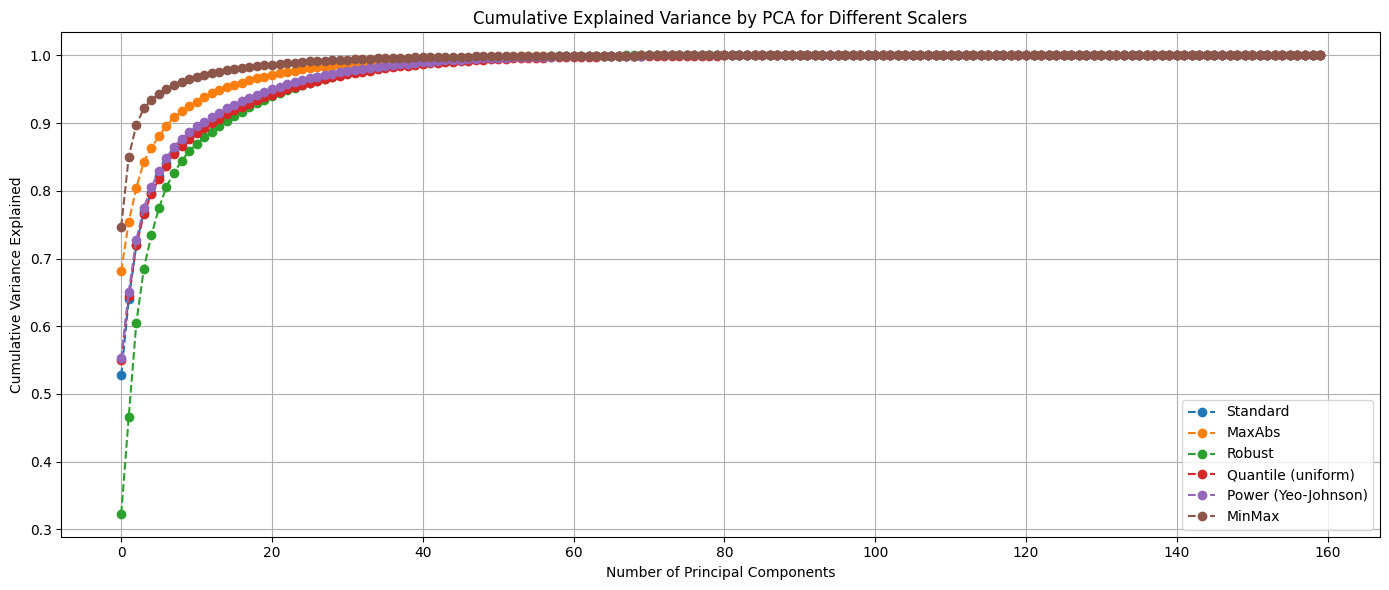

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare scalers in a dict for easy iteration
scalers = {
    "Standard": StandardScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Robust": RobustScaler(),
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
}

# Store cumulative variance per scaler
cum_variances = {}

for name, scaler in scalers.items():
    try:
        scaled = scaler.fit_transform(df_pivot_20)
        pca = PCA()
        X_pca = pca.fit_transform(scaled)
        cum_var = np.cumsum(pca.explained_variance_ratio_)
        cum_variances[name] = cum_var
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Plot all in one figure
plt.figure(figsize=(14, 6))

for name, cum_var in cum_variances.items():
    plt.plot(cum_var, marker='o', linestyle='--', label=name)

plt.title("Cumulative Explained Variance by PCA for Different Scalers")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


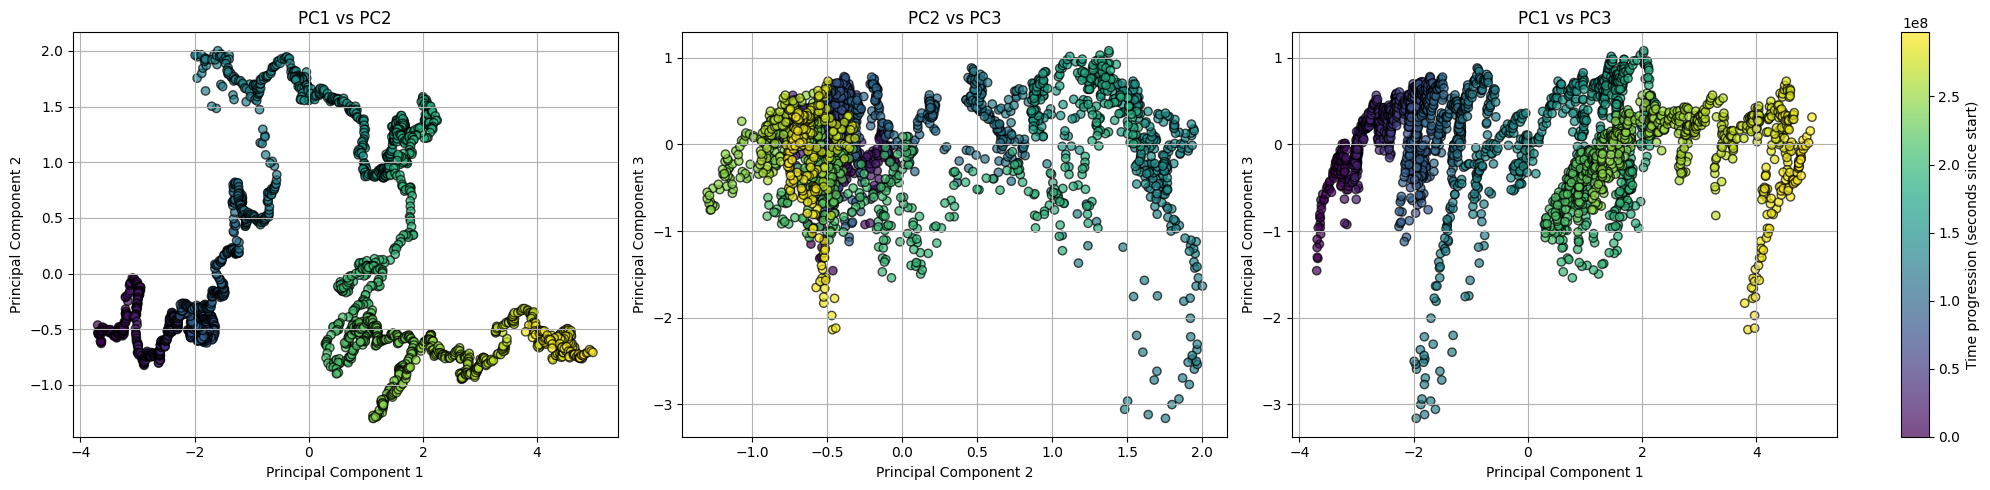

In [18]:
import matplotlib.gridspec as gridspec

# Convert timestamps to numeric
timestamps = pd.to_datetime(df_pivot_20.index)
time_numeric = (timestamps - timestamps.min()).total_seconds()

# Set up figure with gridspec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

# Common colormap
cmap = plt.cm.viridis

# Plot 1: PC1 vs PC2
ax0 = plt.subplot(gs[0])
sc0 = ax0.scatter(X_pca[:, 0], X_pca[:, 1], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel("Principal Component 1")
ax0.set_ylabel("Principal Component 2")
ax0.grid(True)

# Plot 2: PC2 vs PC3
ax1 = plt.subplot(gs[1])
sc1 = ax1.scatter(X_pca[:, 1], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax1.set_title("PC2 vs PC3")
ax1.set_xlabel("Principal Component 2")
ax1.set_ylabel("Principal Component 3")
ax1.grid(True)

# Plot 3: PC1 vs PC3
ax2 = plt.subplot(gs[2])
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax2.set_title("PC1 vs PC3")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 3")
ax2.grid(True)

# Add a colorbar in the dedicated subplot
cax = plt.subplot(gs[3])
cb = plt.colorbar(sc2, cax=cax)
cb.set_label("Time progression (seconds since start)")

plt.tight_layout()
plt.show()


In [ ]:
# 🧠 Observation:
# The first principal component (PC1) increases over time, even though the timestamp is not in the input.

# 🔍 What this likely means:
# The underlying features you're feeding into PCA are themselves changing over time in a directional or trending way.

# 📌 Is this normal?
# Yes, it's possible — but it's a red flag depending on your goals. Here's why:

# ✅ It's normal when:
# The market itself is trending over time (e.g., bull market from 2009–2021).

# Some of your features have non-stationary behavior, like cumulative returns, raw prices, or ratios that naturally grow over time.

# 🚩 It's a problem when:
# Your features are unintentionally leaking time (e.g., trends driven by the date, not market structure).

# The PCA is capturing time progression rather than distinct structural regimes.

# Fixable by transforming input features to remove time-based drift

In [82]:
df_adj.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap', 'log_returns', 'rolling_volatility_20', 'bb_upper', 'bb_middle',
       'bb_lower', 'atr_20', 'volume_pct_change', 'momentum_10', 'rsi_20',
       'sma_10', 'ema_10', 'sma_20', 'ema_20'],
      dtype='object')

In [ ]:
# Check feature stationarity using Augmented Dickey-Fuller test
# p-value > 0.1 = likely non-stationary (bad for PCA)
from statsmodels.tsa.stattools import adfuller

stationary_features = []
for col in df_pivot_20.columns:
    result = adfuller(df_pivot_20[col])
    if result[1] < 0.1:
        stationary_features.append(col)

# print which features are stationary, to keep for PCA
from collections import Counter
prefixes = [ "_".join(v.split("_")[:-1]) for v in stationary_features ]
print(Counter(prefixes))

df_stationary = df_pivot_20[stationary_features]

Counter({'trade_count': 8, 'log_returns': 8, 'rolling_volatility_20': 8, 'volume_pct_change': 8, 'momentum_10': 8, 'rsi_20': 8, 'volume': 7, 'atr_20': 6})


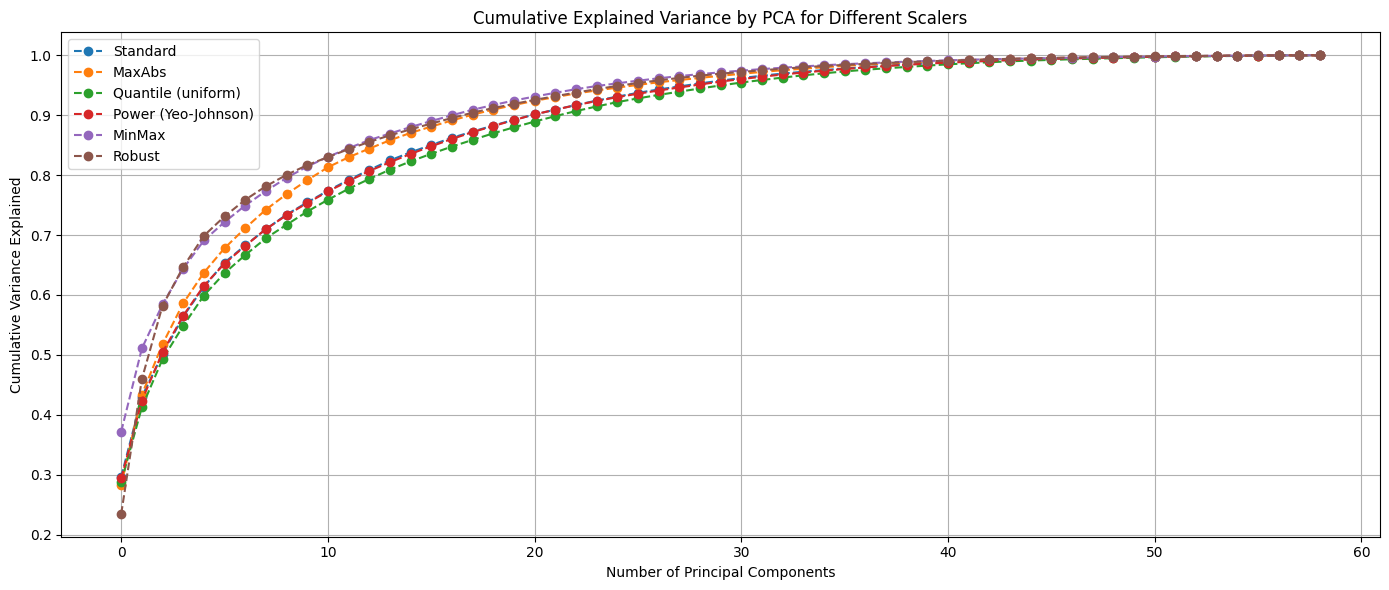

In [ ]:
# Prepare scalers in a dict for easy iteration
scalers = {
    "Standard": StandardScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Robust": RobustScaler(),
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
}

# Store cumulative variance per scaler
cum_variances = {}

for name, scaler in scalers.items():
    try:
        scaled = scaler.fit_transform(df_stationary)
        pca = PCA()
        X_pca = pca.fit_transform(scaled)
        cum_var = np.cumsum(pca.explained_variance_ratio_)
        cum_variances[name] = cum_var
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Plot all in one figure
plt.figure(figsize=(14, 6))

for name, cum_var in cum_variances.items():
    plt.plot(cum_var, marker='o', linestyle='--', label=name)

plt.title("Cumulative Explained Variance by PCA for Different Scalers")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


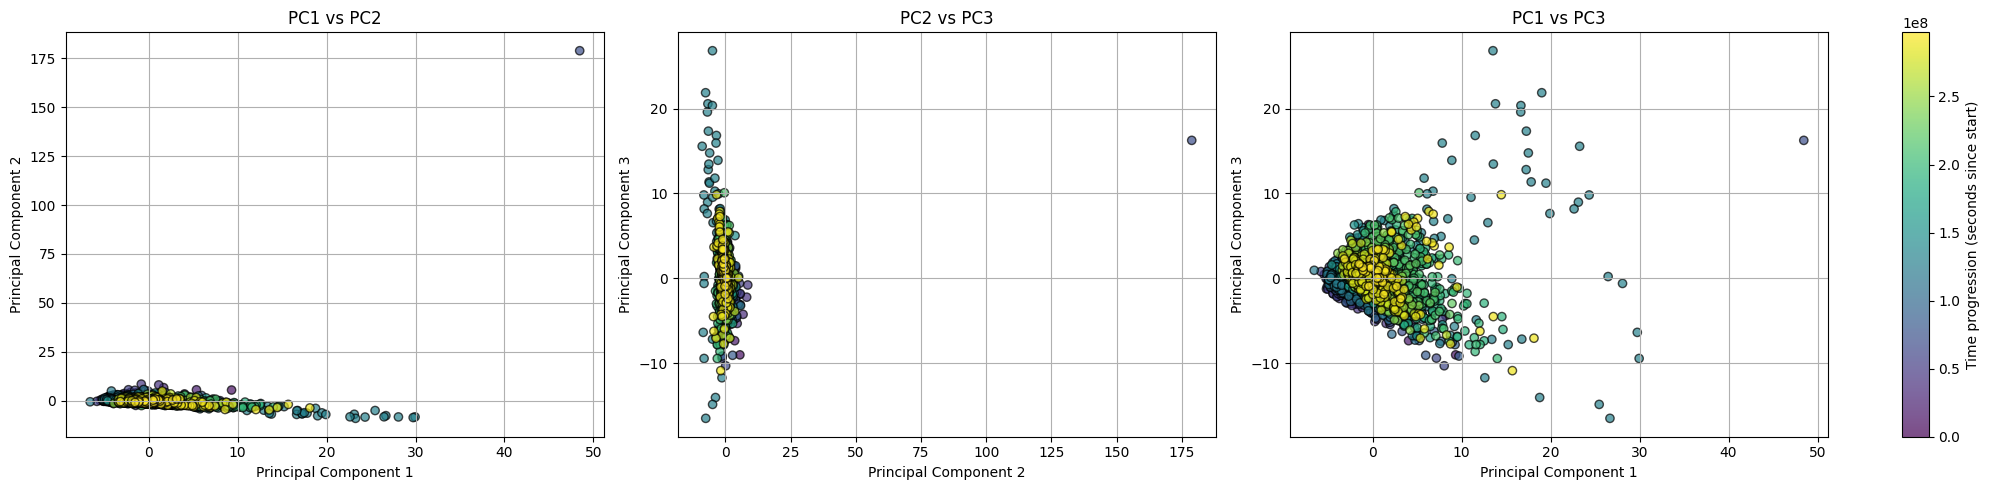

In [22]:
import matplotlib.gridspec as gridspec

# Convert timestamps to numeric
timestamps = pd.to_datetime(df_pivot_20.index)
time_numeric = (timestamps - timestamps.min()).total_seconds()

# Set up figure with gridspec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

# Common colormap
cmap = plt.cm.viridis

# Plot 1: PC1 vs PC2
ax0 = plt.subplot(gs[0])
sc0 = ax0.scatter(X_pca[:, 0], X_pca[:, 1], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel("Principal Component 1")
ax0.set_ylabel("Principal Component 2")
ax0.grid(True)

# Plot 2: PC2 vs PC3
ax1 = plt.subplot(gs[1])
sc1 = ax1.scatter(X_pca[:, 1], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax1.set_title("PC2 vs PC3")
ax1.set_xlabel("Principal Component 2")
ax1.set_ylabel("Principal Component 3")
ax1.grid(True)

# Plot 3: PC1 vs PC3
ax2 = plt.subplot(gs[2])
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax2.set_title("PC1 vs PC3")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 3")
ax2.grid(True)

# Add a colorbar in the dedicated subplot
cax = plt.subplot(gs[3])
cb = plt.colorbar(sc2, cax=cax)
cb.set_label("Time progression (seconds since start)")

plt.tight_layout()
plt.show()


In [23]:
# ##### Rolling Correlations Calculation #####
# # Define rolling window size (e.g., 20 days)
# window = 20

# # Pivot to wide format: rows = dates, columns = symbols, values = 'Close'
# close_pivot = df_adj.pivot(columns='symbol', values='close')

# # Drop rows with NaN values
# close_pivot = close_pivot.dropna()

# # Get all unique pairs of symbols
# symbols = close_pivot.columns
# pairs = [(s1, s2) for i, s1 in enumerate(symbols) for s2 in symbols[i+1:]]

# # Compute rolling correlations and store in a new DataFrame
# rolling_corr_df = pd.DataFrame(index=close_pivot.index)

# for s1, s2 in pairs:
#     rolling_corr = close_pivot[s1].rolling(window).corr(close_pivot[s2])
#     rolling_corr_df[f'corr_{s1}_{s2}_roll{window}'] = rolling_corr

# # Merge with your original DataFrame (if needed)
# df_adj = df_adj.join(rolling_corr_df, how='left')


In [24]:
## BUSCAR UN GRUPO QUE NO TENGA UNA CORRELACION ALTA?????

# # # ##### Correlation Heatmap #####
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Pivot 'Close' prices by symbol; index is already datetime
# pivot_df = df_adj.pivot(columns='symbol', values='close')

# # Optionally drop rows with missing values to ensure clean correlation
# pivot_df = pivot_df.dropna()

# # Compute the correlation matrix
# correlation_matrix = pivot_df.corr()

# # Plot the correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# plt.title("Correlation Matrix of Close Prices by Symbol")
# plt.tight_layout()
# plt.show()
